In [1]:
pip install git+https://github.com/lmssdd/conformalized.git

  Cloning https://github.com/lmssdd/conformalized.git to /private/var/folders/ky/3gp738kd2bd5wv0h4l2p24040000gn/T/pip-req-build-bi_navcj
  Running command git clone --filter=blob:none --quiet https://github.com/lmssdd/conformalized.git /private/var/folders/ky/3gp738kd2bd5wv0h4l2p24040000gn/T/pip-req-build-bi_navcj
  Resolved https://github.com/lmssdd/conformalized.git to commit 95ffd57f532358cd6212a84bb778cbce28f830b2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for conformalized: filename=conformalized-0.14.dev0-py3-none-any.whl size=9154 sha256=1c4f00f2a0b484212bd448b5487f0cc1f40e794dbcc47502b65992bfb6a6a9ec
  Stored in directory: /private/var/folders/ky/3gp738kd2bd5wv0h4l2p24040000gn/T/pip-ephem-wheel-cache-9gf4sjv4/wheels/92/14/26/74925543843baf3b3c5bf97f981de76033a1d9f8f6b474bec3
Successfully built conformalized
  Attempting uninstall


# Prediction Intervals for Conformalized Gradient Boosting Regression

This example shows how quantile regression can be used to create prediction
intervals and the value added of conformalized quantile regression.


Generate some data for a synthetic regression problem by applying the
function f to uniformly sampled random inputs.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

To make the problem interesting, we generate observations of the target y as
the sum of a deterministic term computed by the function f and a random noise
term that follows a centered [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution). To make this even
more interesting we consider the case where the amplitude of the noise
depends on the input variable x (heteroscedastic noise).

The lognormal distribution is non-symmetric and long tailed: observing large
outliers is likely but it is impossible to observe small outliers.



In [3]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise

Split into train, test datasets:



In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Fitting non-linear quantile and least squares regressors

Fit gradient boosting models trained with the quantile loss and
alpha=0.05, 0.5, 0.95.

The models obtained for alpha=0.05 and alpha=0.95 produce a 90% confidence
interval (95% - 5% = 90%).

The model trained with alpha=0.5 produces a regression of the median: on
average, there should be the same number of target observations above and
below the predicted values.



In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

Notice that :class:`~sklearn.ensemble.HistGradientBoostingRegressor` is much
faster than :class:`~sklearn.ensemble.GradientBoostingRegressor` starting with
intermediate datasets (`n_samples >= 10_000`), which is not the case of the
present example.

For the sake of comparison, we also fit a baseline model trained with the
usual (mean) squared error (MSE).



In [6]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

Create an evenly spaced evaluation set of input values spanning the [0, 10]
range.



In [7]:
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

Plot the true conditional mean function f, the predictions of the conditional
mean (loss equals squared error), the conditional median and the conditional
90% interval (from 5th to 95th conditional percentiles).



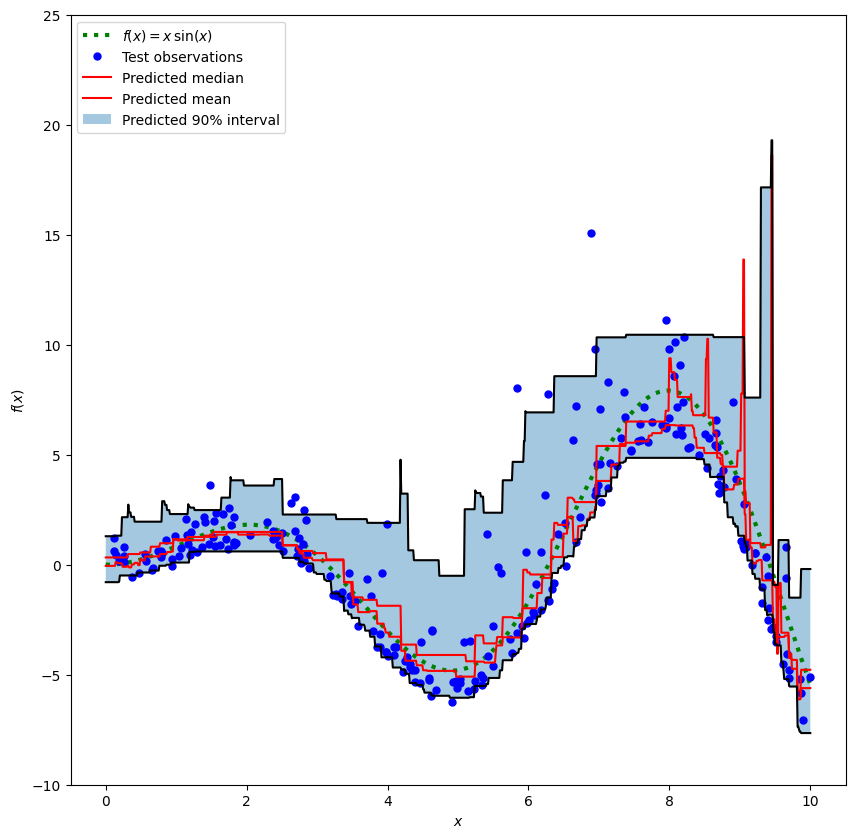

In [8]:
y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "r-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.show()

Comparing the predicted median with the predicted mean, we note that the
median is on average below the mean as the noise is skewed towards high
values (large outliers). The median estimate also seems to be smoother
because of its natural robustness to outliers.

Also observe that the inductive bias of gradient boosting trees is
unfortunately preventing our 0.05 quantile to fully capture the sinoisoidal
shape of the signal, in particular around x=8. Tuning hyper-parameters can
reduce this effect as shown in the last part of this notebook.

## Conformalized predictions

We now performa the same analysis but using the ConfGradienBoostingRegressor

In [9]:
from conformalized import ConfGradientBoostingRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, KFold

# Define the model for the required quantiles
cgb = ConfGradientBoostingRegressor(quantiles=[0.05, 0.5, 0.95])

# Divide the training set in a proper training and a calibration set
X_train_cgb, X_calib, y_train_cgb, y_calib = train_test_split(X_train, y_train, random_state=0)

# Fit the model
cgb.fit(X_train_cgb, y_train_cgb)

# Calibrate the quantile corrections
cgb.calibrate(X_calib, y_calib)

# Gradient boosting forecast
y_pred = cgb.predict(X_test)

# Conformalized forecast
y_conf = cgb.conformalize(y_pred)

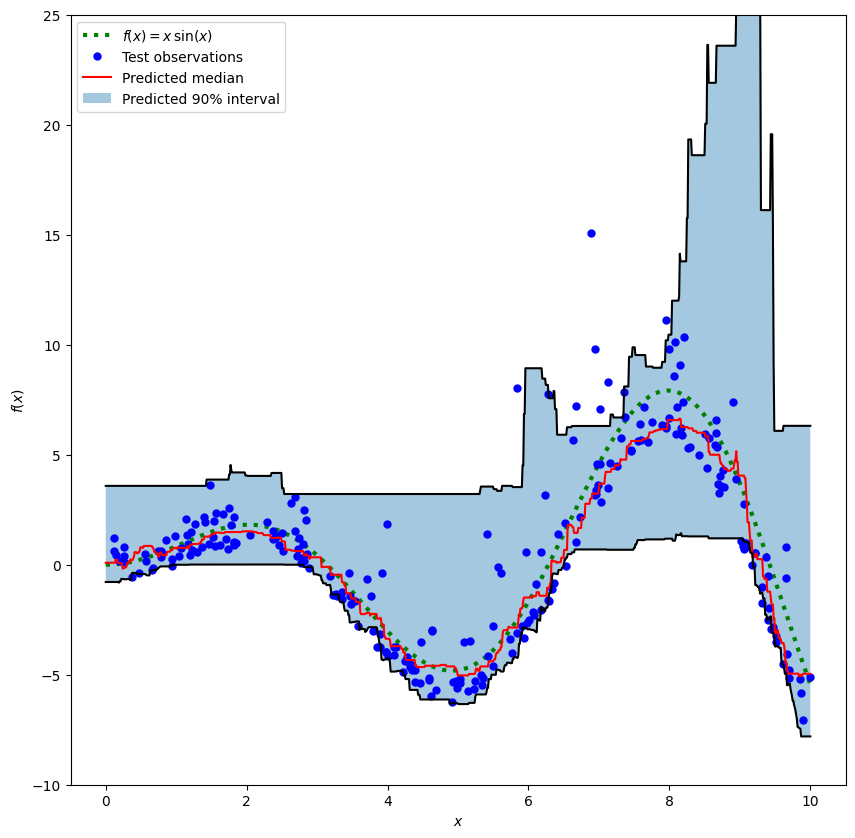

In [10]:
y_plot = cgb.predict(xx)
y_plot = cgb.conformalize(y_plot)

y_lower = y_plot[:,0]
y_med = y_plot[:,1]
y_upper = y_plot[:,2]

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.show()



## Analysis of the error metrics

Measure the models with :func:`~sklearn.metrics.mean_squared_error` and
:func:`~sklearn.metrics.mean_pinball_loss` metrics on the training dataset.



In [11]:
import pandas as pd


def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_train)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_train, y_pred)
    results.append(metrics)
    
y_pred = cgb.predict(X_train)
metrics = {"model": "gb"}
for i, alpha in enumerate(cgb.quantiles):
    metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train, y_pred[:,i], alpha=alpha)
metrics["MSE"] = mean_squared_error(y_train, y_pred[:,1])
results.append(metrics)

metrics = {"model": "cgb"}
y_pred = cgb.conformalize(y_pred)
for i, alpha in enumerate(cgb.quantiles):
    metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train, y_pred[:,i], alpha=alpha)
metrics["MSE"] = mean_squared_error(y_train, y_pred[:,1])
results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.680857,0.680857,0.680857,6.233620
q 0.05,0.081959,0.810384,1.538808,12.438518
q 0.50,0.294879,0.611613,0.928347,9.699392
q 0.95,3.762458,2.067102,0.371746,27.562945
gb,0.122697,0.647414,0.440836,9.908493
cgb,0.123769,0.647424,0.445487,9.907855


One column shows all models evaluated by the same metric. The minimum number
on a column should be obtained when the model is trained and measured with
the same metric. This should be always the case on the training set if the
training converged.

Note that because the target distribution is asymmetric, the expected
conditional mean and conditional median are significantly different and
therefore one could not use the squared error model get a good estimation of
the conditional median nor the converse.

If the target distribution were symmetric and had no outliers (e.g. with a
Gaussian noise), then median estimator and the least squares estimator would
have yielded similar predictions.

We then do the same on the test set.



In [12]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_test)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

y_pred = cgb.predict(X_test)
metrics = {"model": "gb"}
for i, alpha in enumerate(cgb.quantiles):
    metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test, y_pred[:,i], alpha=alpha)
metrics["MSE"] = mean_squared_error(y_test, y_pred[:,1])
results.append(metrics)

metrics = {"model": "cgb"}
y_pred = cgb.conformalize(y_pred)
for i, alpha in enumerate(cgb.quantiles):
    metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test, y_pred[:,i], alpha=alpha)
metrics["MSE"] = mean_squared_error(y_test, y_pred[:,1])
results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,1.002030,0.805545,0.609060,8.760905
q 0.05,0.105428,0.717316,1.329204,7.518949
q 0.50,0.414976,0.607472,0.799968,5.827638
q 0.95,4.230054,2.291533,0.353013,34.043107
gb,0.149418,0.617157,0.493126,5.822267
cgb,0.135883,0.617186,0.498015,5.821861


Errors are higher meaning the models slightly overfitted the data. It still
shows that the best test metric is obtained when the model is trained by
minimizing this same metric.

Note that the conditional median estimator is competitive with the squared
error estimator in terms of MSE on the test set: this can be explained by
the fact the squared error estimator is very sensitive to large outliers
which can cause significant overfitting. This can be seen on the right hand
side of the previous plot. The conditional median estimator is biased
(underestimation for this asymmetric noise) but is also naturally robust to
outliers and overfits less.

## Calibration of the confidence interval

We can also evaluate the ability of the two extreme quantile estimators at
producing a well-calibrated conditional 90%-confidence interval.

To do this we can compute the fraction of observations that fall between the
predictions:



In [13]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

print('qr', 
      coverage_fraction(
          y_train,
          all_models["q 0.05"].predict(X_train),
          all_models["q 0.95"].predict(X_train)
      )
     )
print('gb', 
      coverage_fraction(
          y_train,
          cgb.predict(X_train)[:,0],
          cgb.predict(X_train)[:,2]
      )
     )
print('cgb', 
      coverage_fraction(
          y_train,
          cgb.conformalize(cgb.predict(X_train))[:,0],
          cgb.conformalize(cgb.predict(X_train))[:,2]
      )
     )

qr 0.896
gb 0.8813333333333333
cgb 0.944


On the training set the calibration is very close to the expected coverage
value for a 90% confidence interval.



In [14]:
print('qr', 
      coverage_fraction(
          y_test,
          all_models["q 0.05"].predict(X_test),
          all_models["q 0.95"].predict(X_test)
      )
     )
print('gb', 
      coverage_fraction(
          y_test,
          cgb.predict(X_test)[:,0],
          cgb.predict(X_test)[:,2]
      )
     )
print('cgb', 
      coverage_fraction(
          y_test,
          cgb.conformalize(cgb.predict(X_test))[:,0],
          cgb.conformalize(cgb.predict(X_test))[:,2]
      )
     )

qr 0.796
gb 0.816
cgb 0.872


On the test set the calibration is not good unless the confonformalization is applied.